In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from utils import *

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [3]:
np.random.seed(8)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16379839625501494973
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1827712432552967652
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Loading images

In [4]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading training images, images loaded: 100 
Loading groundtruth images, images loaded: 100 


In [5]:
imgs_train.shape

(100, 400, 400, 3)

In [6]:
gt_imgs_train.shape

(100, 400, 400)

In [7]:
image_size = 400
# Patches for training
img_patches_train = [
    crop_image(imgs_train[i], image_size, image_size) for i in range(n_train)
]
gt_patches_train = [
    crop_image(gt_imgs_train[i], image_size, image_size) for i in range(n_train)
]

# Separate features and labels
X_train = np.asarray(
    [
        img_patches_train[i][j]
        for i in range(len(img_patches_train))
        for j in range(len(img_patches_train[i]))
    ]
)
Y_train = np.asarray(
    [
        gt_patches_train[i][j]
        for i in range(len(gt_patches_train))
        for j in range(len(gt_patches_train[i]))
    ]
)

In [8]:
X_train.shape

(100, 400, 400, 3)

In [9]:
Y_train.shape

(100, 400, 400)

In [10]:
# image_dir_val = "data/validating/images/"
# files = os.listdir(image_dir_val)
# n_val = len(files)
# print(f"Loading validating images, images loaded: {n_val} ")
# imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])
# gt_dir_val = "data/validating/groundtruth/"
# print(f"Loading validating groundtruth, images loaded: {n_val} ")
# gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

In [11]:
# imgs_val.shape

In [12]:
# gt_imgs_val.shape

In [13]:
# image_size = 400
# # Patches for validating
# img_patches_val = [
#     crop_image(imgs_val[i], image_size, image_size) for i in range(n_val)
# ]
# gt_patches_val = [
#     crop_image(gt_imgs_val[i], image_size, image_size) for i in range(n_val)
# ]

# # Separate features and labels
# X_val = np.asarray(
#     [
#         img_patches_val[i][j]
#         for i in range(len(img_patches_val))
#         for j in range(len(img_patches_val[i]))
#     ]
# )
# Y_val = np.asarray(
#     [
#         gt_patches_val[i][j]
#         for i in range(len(gt_patches_val))
#         for j in range(len(gt_patches_val[i]))
#     ]
# )

In [14]:
# X_val.shape

In [15]:
# Y_val.shape

In [16]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [24]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [25]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(900, 456, 456, 3)
(900, 456, 456)


In [26]:
# X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [27]:
# X_val = np.asarray(X_val)
# Y_val = np.asarray(Y_val)

In [28]:
# print(X_val.shape)
# print(Y_val.shape)
# n_val = Y_val.shape[0]

# Create functions to calcualte precision, recall and F-1 in the training of model

In [29]:
def precision(y_true, y_pred):
    """Compute the Precision for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
        Precision (numpy.float64): the Precision of the batch 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Compute the Recall for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       Recall (numpy.float64): the Recal of the batch 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    """Compute the F-1 for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       F-1 (numpy.float64): the F-1 of the batch 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# Erick architecture


In [30]:
class CNN:
    def __init__(self, shape):
        self.shape = shape
        self.model = self.initialize_U_NET(shape)

    def initialize_U_NET(self, shape):
        """Create Network Architecture.
        Args:
            shape (triplet): Size of the input layer height x width x colors (64 x 64 x 3)
        Returns:
            model (Neural Network): Architecture of the model
        """
        # INPUT
        # shape     - Size of the input images
        # OUTPUT
        # model    - Compiled CNN

        # Define hyperparamters
        KERNEL3 = (3, 3)
        KERNEL5 = (5, 5)

        # Define a model
        model = Sequential()

        # Add the layers
        # Selection of the model is described in the report
        # We use padding = 'same' to avoid issues with the matrix sizes
        model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        model.add(Conv2D(512, KERNEL3, padding="same"))
        model.add(LeakyReLU(alpha=0.1))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Dropout(0.2))

        # Flatten it and use regularizers to avoid overfitting
        # The parameters have been chosen empirically
        model.add(Flatten())
        model.add(
            Dense(
                128, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001)
            )
        )
        # model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dropout(0.5))

        # Add output layer
        model.add(
            Dense(2, kernel_regularizer=l2(0.000001), activity_regularizer=l2(0.000001))
        )
        model.add(Activation("sigmoid"))
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(learning_rate=0.001),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):
        """Train the Model.

        Returns:
            History (History_Keras): History of the training
        """
        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="loss", patience=10, verbose=1, restore_best_weights=True,
        )
        # Reduce learning rate on plateau after 5 steps
        lr_callback = ReduceLROnPlateau(
            monitor="loss", factor=0.8, patience=4, verbose=1, cooldown=1,
        )
        save_best = ModelCheckpoint(
            "Erick_dropout_0.2-{epoch:03d}-{f1:03f}.h5",
            save_best_only=True,
            monitor="loss",
            verbose=1,
        )
        callbacks = [lr_callback, save_best, early_stopping]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(
                X_train, Y_train, n_train, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            ),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            #             validation_data=create_minibatch(
            #                 X_val, Y_val, n_val, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE, WIDTH
            #             ),
            #             validation_steps=STEPS_PER_EPOCH / 3,
        )
        return history

    def classify(self, X):
        """Classify Image as either road or not.
        Args:
            X (image): part of the image to classify
        Returns:
            Predictions : Predictions for each patch
        """
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=24)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return predictions.reshape(X.shape[0], -1)

    #         return group_patches(predictions, X.shape[0])

    def load(self, filename):
        """Loads Saved Model.
        Args:
           filename (string): name of the model
           
        """
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        """Saves trained model.
        Args:
           filename (string): name of the model
           
        """
        self.model.save(filename)

In [31]:
# We define parameters of the model
BATCH_SIZE = 300
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 300
STEPS_PER_EPOCH = 100
WIDTH = 448
model = CNN(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0

In [32]:
history = model.train()

Epoch 1/300
 99/100 [============================>.] - ETA: 0s - loss: 0.5463 - accuracy: 0.7569 - recall: 0.7585 - f1: 0.7575
Epoch 00001: loss improved from inf to 0.54624, saving model to Erick_dropout_0.2-001-0.757395.h5
100/100 [==============================] - 41s 411ms/step - loss: 0.5462 - accuracy: 0.7567 - recall: 0.7583 - f1: 0.7574
Epoch 2/300
 99/100 [============================>.] - ETA: 0s - loss: 0.5066 - accuracy: 0.7514 - recall: 0.7523 - f1: 0.7516
Epoch 00002: loss improved from 0.54624 to 0.50641, saving model to Erick_dropout_0.2-002-0.751483.h5
100/100 [==============================] - 39s 387ms/step - loss: 0.5064 - accuracy: 0.7513 - recall: 0.7522 - f1: 0.7515
Epoch 3/300
 99/100 [============================>.] - ETA: 0s - loss: 0.4686 - accuracy: 0.7684 - recall: 0.7675 - f1: 0.7682
Epoch 00003: loss improved from 0.50641 to 0.46818, saving model to Erick_dropout_0.2-003-0.768587.h5
100/100 [==============================] - 38s 378ms/step - loss: 0.4682 

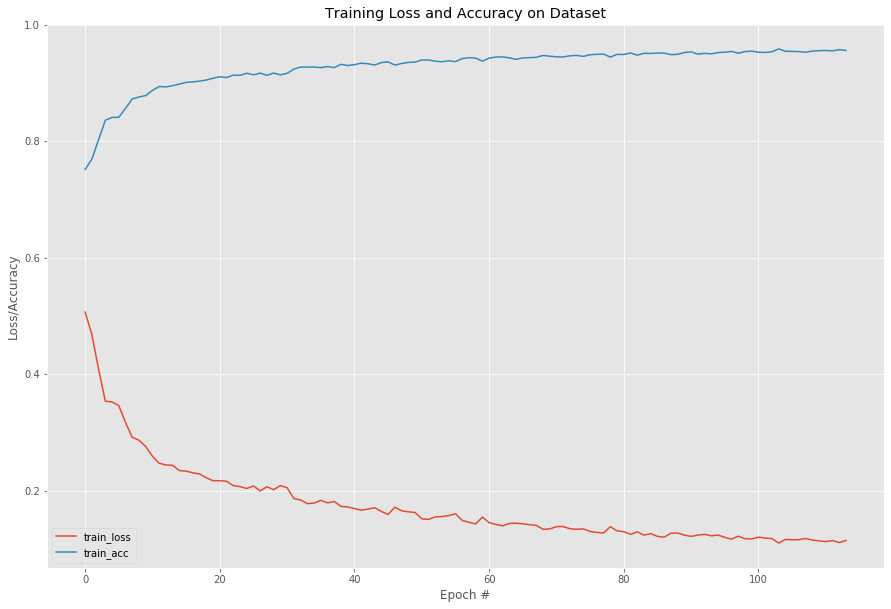

In [33]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
# plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
# plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots/Erick_dropout_0.2.pdf")
plt.show()

In [34]:
# Instantiate the model
model = CNN(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

# Load the model
model.load("Erick_dropout_0.2-105-0.958154.h5")

model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "Erick_dropout_0.2-105-0.958154.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)      